In [1]:
COLAB = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  local_path = '/content/drive/My Drive/github/DeepLDSIR'
else:
  local_path = r'../'

import os
os.chdir(local_path)

import sys
sys.path.insert(0, './models')

Mounted at /content/drive


In [2]:
import os
import tensorflow as tf
import numpy as np
import scipy.io as sio

from utils import *
from models.Alpha8L import *
from matplotlib import pyplot as plt
from admm import ADMM as algADMM

In [3]:
# data_path = "/content/drive/My Drive/hdsp/data/kaist_dataset/train"

data_path = "/content/drive/My Drive/hdsp/data/Arad_dataset/test"

image_name = os.listdir(data_path)[9]
image_path = os.path.join(data_path, image_name)


RGB = [22, 12, 4]
h = sio.loadmat(image_path)['img']
h = np.expand_dims(h,0)         
Batch_size, Img_heigth , Img_width , Channels = h.shape                
coded_aperture = np.load('ca.npy')

y = dd_cassi(h,coded_aperture)

In [4]:
print(coded_aperture.shape)

(1, 512, 542, 1, 1)


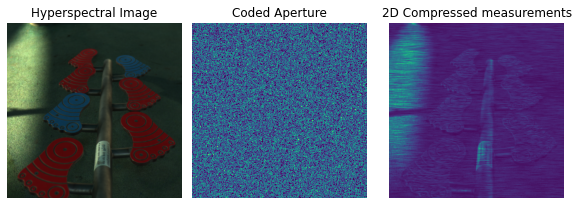

In [5]:
fig, axs = plt.subplots(1,3,constrained_layout=True , figsize=(8,3))
_ = [ x.axis('Off') for x in axs]

axs[0].imshow(h[0,:,:,:][:,:,RGB]) , axs[0].set_title('Hyperspectral Image')
axs[1].imshow(coded_aperture[0,:,:,0,0], aspect=1.06) , axs[1].set_title('Coded Aperture')
axs[2].imshow(y[0,:,:,0]), axs[2].set_title('2D Compressed measurements')
plt.show()

In [6]:
input_size = (Img_heigth, Img_width, Channels)
# weights = './weights/Alpha8L_Kaist.h5'
weights = os.path.join('.', 'weights','Alpha8L_Arad.h5')

In [7]:
optimizad = tf.keras.optimizers.Adam(learning_rate=1e-4)

main_model = HSI_net(coded_aperture, input_size=input_size,  pretrained_weights=weights)

autoencoder = main_model.autoencoder
encode = main_model.encoder
decode = main_model.decoder

autoencoder.compile(optimizer=optimizad, loss='mean_squared_error')
encode.compile(optimizer=optimizad, loss='mean_squared_error')
decode.compile(optimizer=optimizad, loss='mean_squared_error')

In [8]:
algorit_admm = algADMM(main_model)

# epochs , steps = 200 , 20
epochs , steps = 200 , 20
params = [1 , 0.1 , 0.3]

In [9]:
import time 

start = time.time()
h_est = algorit_admm(y,epochs,steps,params)
duration = time.time() - start

||temp-t_old||95.23676641863106||temp2-t2_old||347.81458050840905
||temp-t_old||42.787697||temp2-t2_old||53.096626
||temp-t_old||17.787355||temp2-t2_old||31.201742
||temp-t_old||9.972351||temp2-t2_old||21.595697
||temp-t_old||6.6028967||temp2-t2_old||15.407679
||temp-t_old||4.988929||temp2-t2_old||12.072655
||temp-t_old||4.0262685||temp2-t2_old||9.65495
||temp-t_old||3.505453||temp2-t2_old||8.356731
||temp-t_old||3.2445858||temp2-t2_old||7.495385
||temp-t_old||2.9914336||temp2-t2_old||6.425372
||temp-t_old||2.724644||temp2-t2_old||5.3044615
||temp-t_old||2.3933694||temp2-t2_old||4.193071
||temp-t_old||2.1647685||temp2-t2_old||3.5955276
||temp-t_old||1.9870201||temp2-t2_old||3.0998368
||temp-t_old||1.7022798||temp2-t2_old||2.228625
||temp-t_old||1.5513054||temp2-t2_old||1.7587466
||temp-t_old||1.4494128||temp2-t2_old||1.4345605
||temp-t_old||1.4043473||temp2-t2_old||1.2135457
||temp-t_old||1.3692492||temp2-t2_old||1.0288576
||temp-t_old||1.3501359||temp2-t2_old||0.91915554
recons done


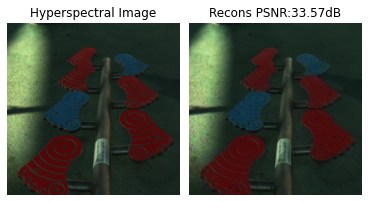

In [10]:
psnr = round( tf.image.psnr(h,h_est,1).numpy()[0],2)
ssim = round( tf.image.ssim(h,h_est,1).numpy()[0],3)

fig, axs = plt.subplots(1,2,constrained_layout=True , figsize=(5,3))
_ = [ x.axis('Off') for x in axs]

axs[0].imshow(h[0,:,:,:][:,:,RGB]) , axs[0].set_title('Hyperspectral Image')
axs[1].imshow(h_est[0,:,:,:][:,:,RGB]) , axs[1].set_title('Recons PSNR:' + str(psnr) + 'dB')

plt.show()

In [11]:
print(psnr, ssim)

33.57 0.917


In [12]:
data = {
    'data' : h_est[0],
    'psnr': psnr,
    'ssim': ssim,
    'time' : duration,
}

save_path =  f'/content/drive/My Drive/hdsp/deep_learning/resultados/recons/quality/LDSR/{image_name}'
print(save_path)

sio.savemat(save_path, data)

/content/drive/My Drive/hdsp/deep_learning/resultados/recons/quality/LDSR/ARAD_HS_0455.mat
